<a href="https://colab.research.google.com/github/lucaatorelli/CircularLoopstation/blob/master/23_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CPAC - P2 - Synesthetic Profile (Prototype)

##**Setup**

In [ ]:
import os
import json
import time
import requests
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from skimage import color

In [ ]:
#Directory check
if os.getcwd() is not '/content': os.chdir('/content')
cd = os.getcwd()
print ("The current working directory is %s" % cd)

The current working directory is /content


###Spotify token for audio analysis

In [ ]:
# %% Let's start with the token
# 1) go to https://developer.spotify.com/console/get-audio-analysis-track/?id=06AKEBrKUckW0KREUWRnvT
# 2) press "try it"
# 3) login
# 4) agree 
# 5) execute this cell and give the script the token (see above)

token=input("Give me the token\n")
header={"Authorization": "Bearer %s"%token}

Give me the token
BQBmpUyw5XSVWetgR7X8Ot512X5QeTstdiUedWsC59hPHAgLa3ynsy8rWTIF-ZVA_fGoT6ZgdhvF0HooOrSGeNJ9zJmJ_0ouQyN4pFWNQaPES01a1ByA7ZZw9AQlne4cYjdG8ZM5DwS2IApkT9JxOhWWs6xtoWsxUuh7xacXoKaJXExISZZph_icckE46R2ZW6NM7MuC


###Dataset reading

In [ ]:
Dataset_name = "Songlist-Luca.json" #Write here the name of your dataset

assert os.path.exists(Dataset_name), "Please put here a list of songs"

with open(Dataset_name,'r') as fp:
    songs=json.load(fp)["songs"]

##**Feature extraction**

In [ ]:
# Get the audio features
search_url="https://api.spotify.com/v1/search"
audio_feature_url="https://api.spotify.com/v1/audio-features"
audio_features=[]
index = 0

for song in songs:
    params={"q": song["artist"]+" "+song["title"], "type": "track"}
    req=requests.get(url=search_url, params=params,headers=header)
    assert req.status_code==200, req.content
    answer=req.json()    
    results=answer["tracks"]["items"]
    if len(results)==0:
        print("I couldn't find %s"%params["q"])
        continue    
    params={"ids":results[0]["id"]}
    req=requests.get(url=audio_feature_url, params=params, headers=header)
    assert req.status_code==200, req.content
    audio_features_song=req.json()["audio_features"][0]
    audio_features_song["title"]=results[0]["name"]
    audio_features_song["artist"]=results[0]["artists"][0]["name"]
    audio_features_song["preview_url"]=results[0]["preview_url"] #Retrieve the preview url
    audio_features.append(audio_features_song)

    print("Song:", song["title"], "(" + song["artist"] + ")")

    #for feature in ["valence", "energy", "acousticness"]:
        #print("%s: %1.f %%"%(feature, 100*audio_features[index][feature]))
    
    index += 1
    print('\n')

    time.sleep(1)

Song: Ultralight Beam (Kanye West)


Song: Father Stretch My Hands Pt. 1 (Kanye West)


Song: Pt. 2 (Kanye West)


Song: Famous (Kanye West)


Song: Feedback (Kanye West)


Song: Low Lights (Kanye West)


Song: Highlights (Kanye West)


Song: Wolves (Kanye West)


Song: 30 Hours (Kanye West)


Song: No More Parties In LA (Kanye West)


Song: Say You Will (Kanye West)


Song: EARFQUAKE (Tyler, The Creator)


Song: Whoville (Tyler, The Creator)


Song: Lights On (feat. Ryan Beatty & Santigold) (Tyler, The Creator)


Song: Hot Chocolate (feat. Jerry Paper) (Tyler, The Creator)


Song: Big Bag (Tyler, The Creator)


Song: When Gloves Come Off (feat. Ryan Beatty) (Tyler, The Creator)


Song: Cindy Lou's Wish (Tyler, The Creator)


Song: Who Dat Boy (feat. A$AP Rocky) (Tyler, The Creator)


Song: Where This Flower Blooms (feat. Frank Ocean) (Tyler, The Creator)


Song: IGOR'S THEME (Tyler, The Creator)


Song: Starboy (The Weeknd)


Song: I Feel It Coming (The Weeknd)


Song: Wasted Times (T

In [ ]:
# Feature Selection
for dic in audio_features:
  for key in list(dic):
    if key not in ["energy", "acousticness", "valence"]:
      dic.pop(key)

##**Clustering**

###Model building

In [ ]:
# Model building
Y = np.asarray(audio_features)

feature_space = []

num_cluster = 3

for dic in audio_features:
  feature_space.append(tuple(dic.values()))

model = sklearn.cluster.KMeans(n_clusters = num_cluster)
labels = model.fit_predict(feature_space)

print("You have", labels.shape[0], "songs in the feature space, organized in", num_cluster, "clusters.")

# Cardinality computation:
cardinalità = []

for index in range(num_cluster):
  cardinalità.append(np.sum(labels == index))

max_cluster = cardinalità.index(np.max(cardinalità)) #index of the largest cluster
cardinalità = cardinalità/np.sum(cardinalità)

###Clustering plots

In [ ]:
# 3d scatterplot using plotly
Scene = dict(xaxis=dict(title='Energy'),yaxis = dict(title='Acousticness'),zaxis = dict(title='Valence'))

# Construction of axises matrix
axises = np.zeros((len(labels)+num_cluster, num_cluster))
i = 0

for triplet in feature_space:
  axises[i,0] = triplet[0]
  axises[i,1] = triplet[1]
  axises[i,2] = triplet[2]
  i+=1

# Plot
trace = go.Scatter3d(x=axises[:labels.shape[0], 0], y=axises[:labels.shape[0], 1], z=axises[:labels.shape[0], 2], 
                     mode='markers',
                     marker=dict(color = labels, size= 8, line=dict(color= 'black',width = 10)))

layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [ ]:
# Centroids computation
centers = np.array(model.cluster_centers_)

# Plot with centroids
for i in np.arange(len(centers)):
  axises[labels.shape[0]+i, 0] = centers[i, 0]
  axises[labels.shape[0]+i, 1] = centers[i, 1]
  axises[labels.shape[0]+i, 2] = centers[i, 2]

trace = go.Scatter3d(x=axises[:, 0], y=axises[:, 1], z=axises[:, 2], 
                     mode='markers',
                     marker=dict(color = labels, size= 8, line=dict(color= 'black',width = 10)))

layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

###Largest cluster analysis (optional)

In [ ]:
#Largest cluster points extraction
cluster_points = []

for i in range(len(labels)):
  if labels[i] == max_cluster:
    cluster_points.append(feature_space[i])

38


In [ ]:
# 3d scatterplot using plotly
Scene = dict(xaxis=dict(title='Energy'),yaxis = dict(title='Acousticness'),zaxis = dict(title='Valence'))

# Construction of axises matrix
axises = np.zeros((len(cluster_points)+num_cluster, num_cluster))
i = 0

for triplet in cluster_points:
  axises[i,0] = triplet[0]
  axises[i,1] = triplet[1]
  axises[i,2] = triplet[2]
  i+=1

# Plot
trace = go.Scatter3d(x=axises[:len(cluster_points), 0], y=axises[:len(cluster_points), 1], z=axises[:len(cluster_points), 2], 
                     mode='markers',
                     marker=dict(color = 'grey', size= 8, line=dict(color= 'black',width = 10)))

layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 600,width = 600)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [ ]:
# Second clustering
model = sklearn.cluster.KMeans(n_clusters = num_cluster)
labels_max = model.fit_predict(cluster_points)

# 3d scatterplot using plotly
Scene = dict(xaxis=dict(title='Energy'),yaxis = dict(title='Acousticness'),zaxis = dict(title='Valence'))

# Construction of axises matrix
axises = np.zeros((len(cluster_points)+num_cluster, num_cluster))
i = 0

for triplet in cluster_points:
  axises[i,0] = triplet[0]
  axises[i,1] = triplet[1]
  axises[i,2] = triplet[2]
  i+=1

# Plot
trace = go.Scatter3d(x=axises[:len(cluster_points), 0], y=axises[:len(cluster_points), 1], z=axises[:len(cluster_points), 2], 
                     mode='markers',
                     marker=dict(color = labels_max, size= 8, line=dict(color= 'black',width = 10)))

layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 600,width = 600)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

##**Palette extraction**

###Color mapping

In [ ]:
# Mapping definition
def ycbcrtorgb(y, cb, cr):
       r = (y + 1.402 * (cr-128))/255
       if r > 1: r = 1
       if r < 0: r = 0

       g = (y - .34414 * (cb-128) -  .71414 * (cr-128))/255
       if g > 1: g = 1
       if g < 0: g = 0

       b = (y + 1.772 * (cb-128))/255
       if b > 1: b = 1
       if b < 0: b = 0

       return r, g, b

In [ ]:
# Features-to-color mapping  (energy, acousticness, valence) ---> (Cr, Cb, Y)
# YCbCr ranges: Y = [16:235], Cb = [16:240], Cr = [16:240]

colors = np.zeros((num_cluster,3))
colors_rgb = []
index = 0

for triplet in centers:  

  # Y
  colors[index, 2] = 16*(1-triplet[1]) + 235*triplet[1]
  # Cb
  colors[index, 1] = 16*(1-triplet[2]) + 240*triplet[2]
  # Cr
  colors[index, 0] = 16*(1-triplet[0]) + 240*triplet[0]

  image = np.zeros((1,3))

  colors_rgb.append(ycbcrtorgb(colors[index,0], colors[index,1], colors[index,2]))

  index += 1

###Palette plot

([<matplotlib.patches.Wedge at 0x7f7b8f4dbfd0>,
 [Text(0.8098740465485804, 2.0455082568220124, ''),
  Text(-2.172914368642616, -0.3441557010227532, ''),
  Text(1.1198910366411619, -1.8936325055434553, '')])

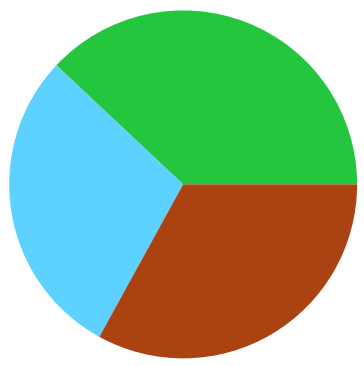

In [ ]:
# Pie plot
plt.pie(cardinalità, colors = colors_rgb, radius = 2)